In [1]:
import sys

sys.path.append('../..')
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from datasets import load_from_disk
from src.hyperdas.data_utils import generate_ravel_dataset, get_ravel_collate_fn, filter_dataset

from transformers import AutoTokenizer
import torch

tokenizer = AutoTokenizer.from_pretrained("/nlp/scr/sjd24/llama3-8b")

tokenizer.padding_side = "left"
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id

from src.hyperdas.llama3.model import RavelInterpretorHypernetwork

hypernetwork = RavelInterpretorHypernetwork(
    model_name_or_path="/nlp/scr/sjd24/llama3-8b",
    num_editing_heads=32,
    intervention_layer=15,
    subspace_module="ReflectSelect",
    das_dimension=128,
    break_asymmetric=False,
)
hypernetwork = hypernetwork.to("cuda")
hypernetwork.load_model("/nlp/scr/sjd24/HyperDAS/RAVEL-Full")

/nlp/scr/sjd24/miniconda3/envs/hypernet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/sailhome/sjd24/HyperDAS/experiments/RAVEL/../../src/hyperdas/llama3/model.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more

In [2]:
test_datasets = {
    "City": load_from_disk("./data/ICLR/city"),
    "Nobel Prize Winner": load_from_disk("./data/ICLR/nobel_prize_winner"),
    "Occupation": load_from_disk("./data/ICLR/occupation"),
    "Physical Object": load_from_disk("./data/ICLR/physical_object"),
    "Verb": load_from_disk("./data/ICLR/verb"),
}

In [42]:
collate_fn = get_ravel_collate_fn(
    tokenizer, 
    add_space_before_target=True, 
    contain_entity_position=True, 
    source_suffix_visibility=True, 
    base_suffix_visibility=True
)

In [4]:
icl_stat_results = dict()
icl_prompt_ratio = dict()

for domain in test_datasets.keys():
    
    print(f"Domain: {domain}")
    dataloader = DataLoader(test_datasets[domain], batch_size=16, collate_fn=collate_fn, shuffle=False)
    is_icl = [f == "icl" for f in test_datasets[domain]["base_template_type"]]
    
    accs, loss, correct_idx = hypernetwork.eval_accuracy(dataloader, inference_mode="bidding_argmax", eval_n_label_tokens=3)
    
    icl_total, icl_correct = 0, 0
    non_icl_total, non_icl_correct = 0, 0

    for i, it_is_icl in enumerate(is_icl):
        if it_is_icl:
            icl_total += 1
            if i in correct_idx:
                icl_correct += 1
        else:
            non_icl_total += 1
            if i in correct_idx:
                non_icl_correct += 1
                
    icl_prompt_ratio[domain] = icl_total / (icl_total + non_icl_total)
    icl_stat_results[domain] = {
        "icl_acc": icl_correct / icl_total,
        "non_icl_acc": non_icl_correct / non_icl_total,
    }

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Domain: City


Domain: Nobel Prize Winner
Domain: Occupation
Domain: Physical Object
Domain: Verb


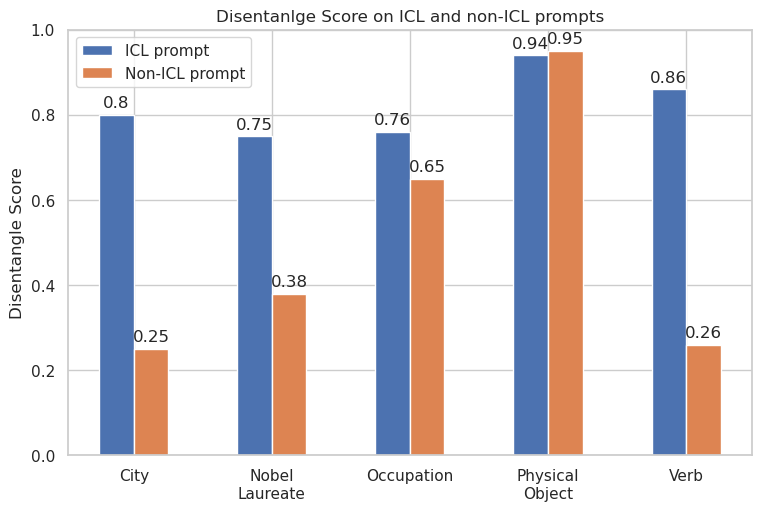

<Figure size 640x480 with 0 Axes>

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")
domains = []
disentangle_accuracies = {
    'ICL prompt': [],
    'Non-ICL prompt': [],
}

for d in icl_stat_results.keys():
    domains.append(d)
    disentangle_accuracies['ICL prompt'].append(round(icl_stat_results[d]['icl_acc'], 2))
    disentangle_accuracies['Non-ICL prompt'].append(round(icl_stat_results[d]['non_icl_acc'], 2))

domains[1] = "Nobel\nLaureate"
domains[3] = "Physical\nObject"

x = np.arange(len(domains))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(7.5, 5))

for attribute, measurement in disentangle_accuracies.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1
    
    
"""for i in range(len(domains)):
    ratio = icl_prompt_ratio[list(icl_stat_results.keys())[i]]
    print(round(ratio * 100, 1))
    
    domains[i] = domains[i] + f"\n({round(ratio * 100, 1)}%)"""

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Disentangle Score')
ax.set_title('Disentanlge Score on ICL and non-ICL prompts')
ax.set_xticks(x + width / 2, domains)
ax.legend(loc='upper left', ncols=1)
ax.set_ylim(0, 1)

plt.show()

plt.tight_layout()
fig.savefig("disentangle_score_comparison.pdf")

In [40]:
icl_prompt_ratio

{'City': 0.8312651331719129,
 'Nobel Prize Winner': 0.8747051886792453,
 'Occupation': 0.9680111265646731,
 'Physical Object': 0.939148786493141,
 'Verb': 0.9665404040404041}

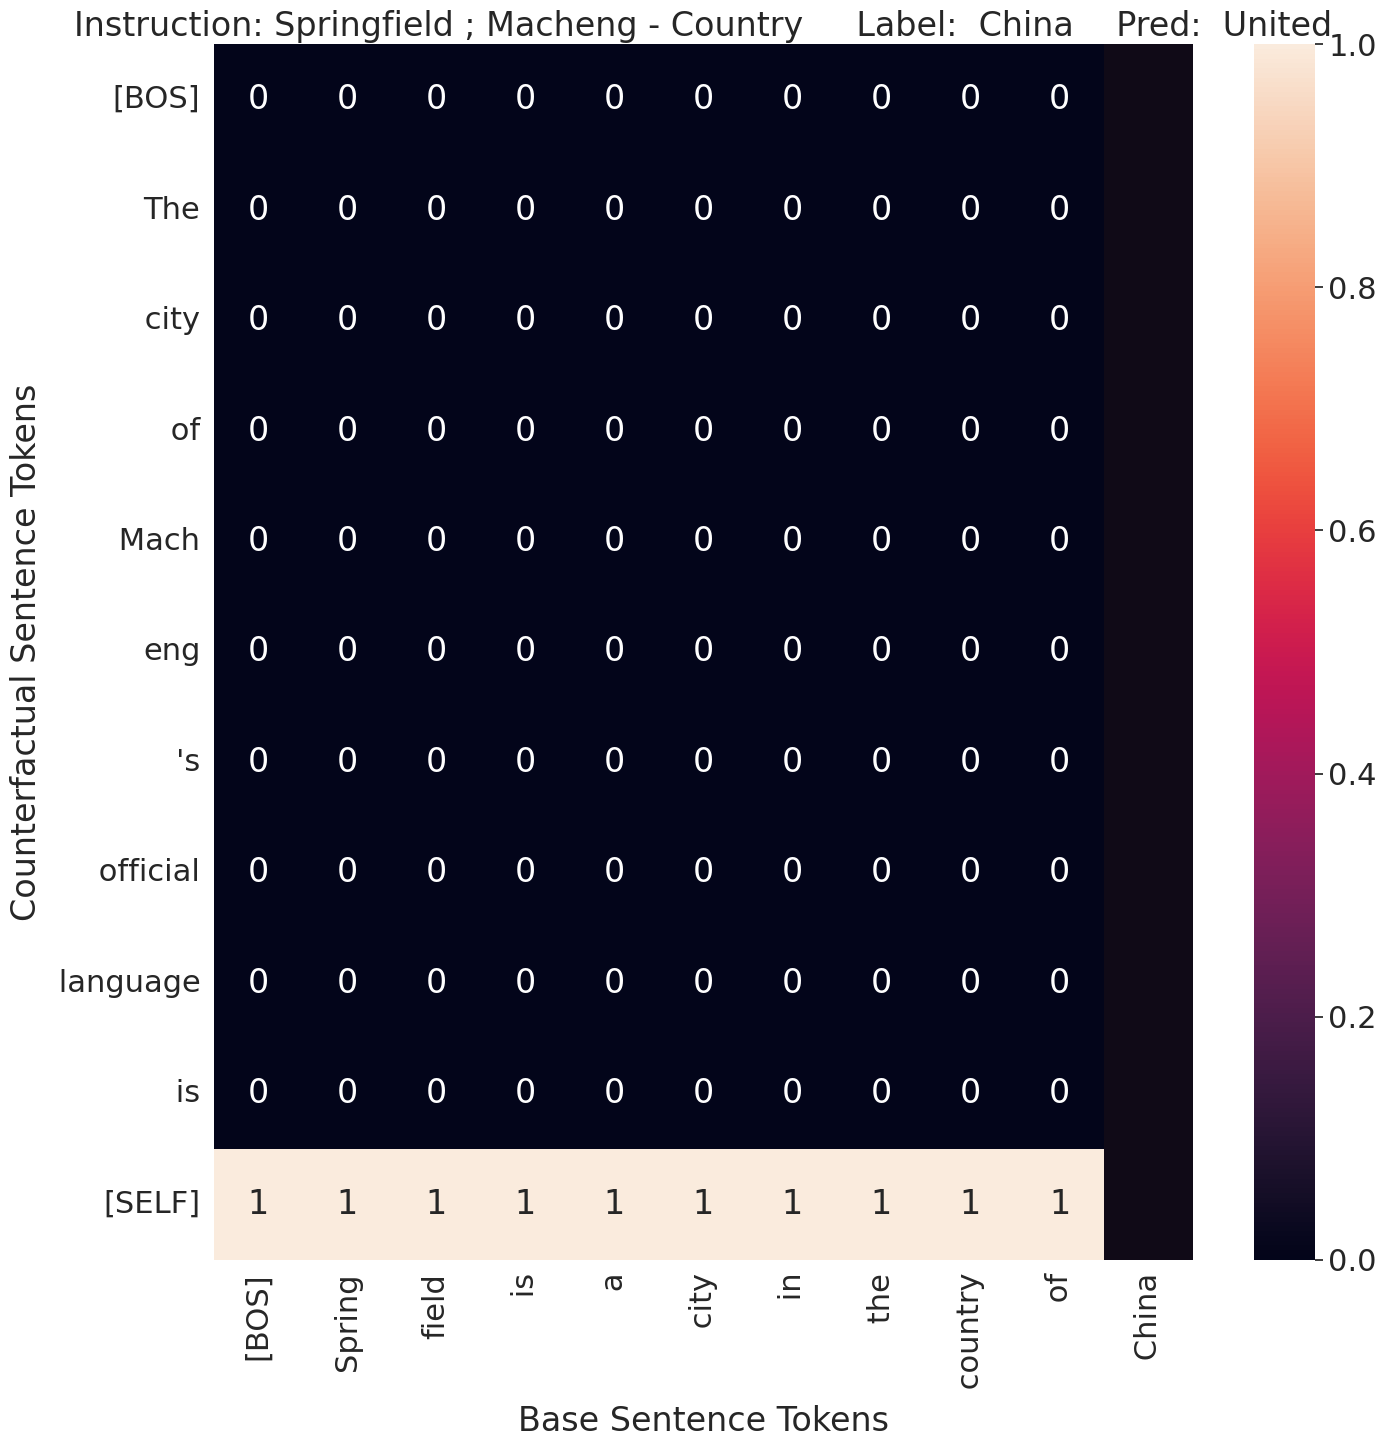

In [44]:
# hypernetwork.interpretor.bidding_threshold = 0.2
import seaborn as sns

dataloader = DataLoader(test_datasets["City"], batch_size=16, collate_fn=collate_fn, shuffle=False)

fig, ax = hypernetwork.plot_heatmap(
    dataloader, 
    idxs=10, 
    inference_mode="bidding_argmax", 
    annot=True, batch_size=16, 
    indicate_masked_tokens=True,
    digits=1,
    font_scale=2
)

fig.tight_layout()
fig.savefig("unified_hyperdas_heatmap_pattern.pdf")